In [404]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

In [405]:
data = pd.read_csv('abalone.data')
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


**Стать за допомогою лейбл енкодера перетворили на числове значення**

In [406]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   int32  
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole weight    4177 non-null   float64
 5   shucked weight  4177 non-null   float64
 6   viscera weight  4177 non-null   float64
 7   shell weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int32(1), int64(1)
memory usage: 277.5 KB


**Немає пропусків та категоріальних значень**

In [407]:
# data['l*d'] = data['diameter'] * data['length'] * data['height']
# data['weight_sum'] = data['whole weight'] +  data['viscera weight'] + data['shell weight'] + data['shucked weight']
# data['l*d*w'] = data['l*d'] * data['weight_sum']
# data = data.drop(columns=['diameter', 'length', 'whole weight', 'viscera weight', 'shell weight', 'l*d', 'weight_sum', 'shucked weight'])
data = data.drop(columns=['diameter', 'length', 'whole weight', 'viscera weight', 'shell weight'])

**Усунення кореляцій. Пробував різні варіанти зі створенням нових фіч, але видалення виявилось найбільш ефективним з усього, що робив.**

<Axes: >

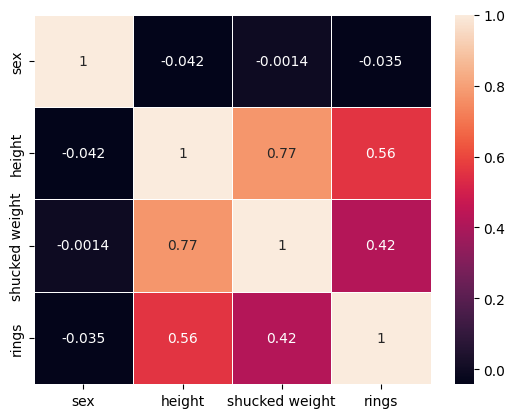

In [408]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, linewidth=.5, robust=True)

In [386]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data.drop(columns=['rings']))
X_train, X_test, y_train, y_test = train_test_split(data_sc, data.rings, train_size=.66, random_state=17, shuffle=True)

**Застосував масштабування та розділив датасет, стратіфай неможливо застосувати - багато класів мають недостатаню кількість представників**

In [387]:
knn_reg = KNeighborsRegressor(n_neighbors=5)
cv_sc = cross_val_score(knn_reg, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")

Cross-Validation Scores: [0.36787873 0.45756326 0.38669407 0.40065453]


**Датасет не ідеально але збалансований**

In [388]:
knn_reg.fit(X_train, y_train)

print(f'Train Score: {knn_reg.score(X_train, y_train)}')
print(f'Test Score: {knn_reg.score(X_test, y_test)}')

Train Score: 0.47242721363774
Test Score: 0.389569786087705


**На тестувальних даних модель поводиться трохи гірше, але не критично**

In [389]:
def error_est(model, X_train, X_test, y_train, y_test):
    y_train_pred = np.around(model.predict(X_train), 0)
    y_test_pred = np.around(model.predict(X_test), 0)

    return {
        "MSE Train": round(mean_squared_error(y_train, y_train_pred), 3),
        "MSE Test": round(mean_squared_error(y_test, y_test_pred), 3),
        "RMSE Train": round(root_mean_squared_error(y_train, y_train_pred), 3),
        "RMSE Test": round(root_mean_squared_error(y_test, y_test_pred), 3),
        "MAE Train": round(mean_absolute_error(y_train, y_train_pred), 3),
        "MAE Test": round(mean_absolute_error(y_test, y_test_pred), 3),
    }

error_est(knn_reg, X_train, X_test, y_train, y_test)

{'MSE Train': 5.573,
 'MSE Test': 6.36,
 'RMSE Train': 2.361,
 'RMSE Test': 2.522,
 'MAE Train': 1.646,
 'MAE Test': 1.758}

**На МСЕ помилки доволі високі, але інші види краще, можлива причина - велика кількість класів та аутлаєри, що сильно підіймають показник**

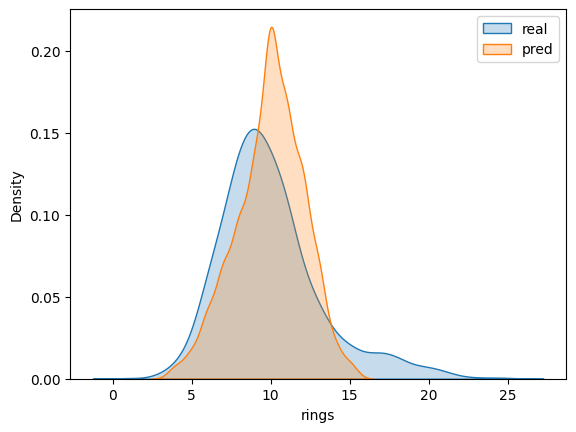

In [390]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(np.around(knn_reg.predict(X_test), 0), fill=True, label='pred')
plt.legend()

**За графіком видно, що модель не затрагує крайніх значень та існує тенденція помилкового присудження класів в районі 10, але в цілому веде себе непогано**

In [409]:
param_grid = {
    'n_neighbors': np.arange(5, 21),  
}

grid_search = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_knn_reg = grid_search.best_estimator_
y_pred = best_knn_reg.predict(X_test)

print(f'Best n_neighbors: {grid_search.best_params_["n_neighbors"]}')
error_est(knn_reg, X_train, X_test, y_train, y_test)

Best n_neighbors: 20


{'MSE Train': 5.573,
 'MSE Test': 6.36,
 'RMSE Train': 2.361,
 'RMSE Test': 2.522,
 'MAE Train': 1.646,
 'MAE Test': 1.758}